In [1]:
import random
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import MONGO_URL, END_DATE, GITHUB_TOKENS
from scripts.analysis import data, plot

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
plot.init_matplotlib()

W, H = 6, 2.5

In [8]:
client = MongoClient(MONGO_URL)
db = client['fake_stars']
#collection = db['fake_actor_events']
collection = db['fake_actor_events']
documents = list(collection.find({}))

df = pd.DataFrame(documents)

repos_with_campaign = data.get_repos_with_campaign()
low_activity_actors = data.get_unique_actors(
    "low_activity_stars", {"low_activity": True}
)
clustered_actors = data.get_unique_actors("clustered_stars", {"clustered": True})
low_activity_actors_in_campaign = data.get_unique_actors(
    "low_activity_stars",
    {"low_activity": True, "repo": {"$in": list(repos_with_campaign)}},
)
clustered_actors_in_campaign = data.get_unique_actors(
    "clustered_stars")
    
df = df[df.actor.isin(low_activity_actors_in_campaign | clustered_actors_in_campaign)]

def compute_actor_features(df):
    # Group by actor and calculate total and activity-specific counts
    actor_group = df.groupby('actor').agg(
        total_activities=('type', 'count'),
        stars=('type', lambda x: (x == 'WatchEvent').sum()),
        issues=('type', lambda x: (x == 'IssuesEvent').sum()),
        prs=('type', lambda x: (x == 'PullRequestEvent').sum()),
        creates=('type', lambda x: (x == 'CreateEvent').sum()),
        forks=('type', lambda x: (x == 'ForkEvent').sum()),
        pushs=('type', lambda x: (x == 'PushEvent').sum()),
        comments=('type', lambda x: ((x.str.contains('Comment')) | x.str.contains('Review')).sum())
    ).reset_index()
    N = actor_group['total_activities']
    # Calculate the percentages of each activity type
    actor_group['star_ratio'] = actor_group['stars'] / N

    actor_group['issue_ratio'] = actor_group['issues'] / N

    actor_group['pr_ratio'] = actor_group['prs'] / N

    actor_group['create_ratio'] = actor_group['creates'] / N

    actor_group['fork_ratio'] = actor_group['forks'] / N

    actor_group['push_ratio'] = actor_group['pushs'] / N
    
    actor_group['comment_ratio'] = actor_group['comments'] / N
    actor_group['other_ratio'] = 1- (actor_group['star_ratio'] + actor_group['issue_ratio']
                                     +actor_group['pr_ratio'] + actor_group['create_ratio']
                                     +actor_group['fork_ratio'] + actor_group['push_ratio']
                                     +actor_group['comment_ratio'])
    actor_group.fillna(0, inplace=True)

    return actor_group


# Compute the features
actor_features = compute_actor_features(df)

features = actor_features[['star_ratio', 'issue_ratio', 'pr_ratio', 'comment_ratio',
                           'create_ratio', 'fork_ratio', 'push_ratio', 'other_ratio', 'total_activities']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

TypeError: get_unique_actors() missing 1 required positional argument: 'query'

In [6]:
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.cluster import SpectralClustering
k_values = range(2, 8)

# List to store the silhouette scores for each k
silhouette_scores = []

for k in k_values:
    speatral_model = SpectralClustering(n_clusters=k, random_state=42).fit(scaled_features)
    labels = speatral_model.labels_
    silhouette_scores.append(metrics.silhouette_score(scaled_features, labels, metric='euclidean'))
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()


KeyboardInterrupt: 

In [7]:
# spectral clustering algorithm
from sklearn.cluster import SpectralClustering
spectral_clustering = SpectralClustering(
    n_clusters=3,
    random_state=42,
    assign_labels='kmeans',  # Options: 'kmeans' or 'discretize'
    affinity='nearest_neighbors'  # Options: 'rbf', 'nearest_neighbors', 'precomputed'
)

# Fit and predict cluster labels
actor_features['cluster'] = spectral_clustering.fit_predict(scaled_features)
ratio_columns = ['star_ratio', 'issue_ratio', 'pr_ratio', 'create_ratio',
                 'fork_ratio', 'push_ratio', 'comment_ratio','other_ratio','total_activities']

cluster_means = actor_features.groupby('cluster')[ratio_columns].mean()

# Print the cluster means
print(cluster_means)
cluster_counts = actor_features.groupby('cluster').size().reset_index(name='actor_count')
print(cluster_counts)


/home/felixyang/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


         star_ratio  issue_ratio  pr_ratio  create_ratio  fork_ratio  \
cluster                                                                
0           0.57878      0.01786  0.016171      0.078506    0.096073   
1           1.00000      0.00000  0.000000      0.000000    0.000000   
2           1.00000      0.00000  0.000000      0.000000    0.000000   

         push_ratio  comment_ratio  other_ratio  total_activities  
cluster                                                            
0          0.169601       0.029335     0.013674        384.716517  
1          0.000000       0.000000     0.000000          1.159915  
2          0.000000       0.000000     0.000000          7.962963  
   cluster  actor_count
0        0         4353
1        1         5653
2        2           81


/tmp/ipykernel_1379899/1292538697.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(event_types, rotation=45, ha='right')
/tmp/ipykernel_1379899/1292538697.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(event_types, rotation=45, ha='right')
/tmp/ipykernel_1379899/1292538697.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(event_types, rotation=45, ha='right')


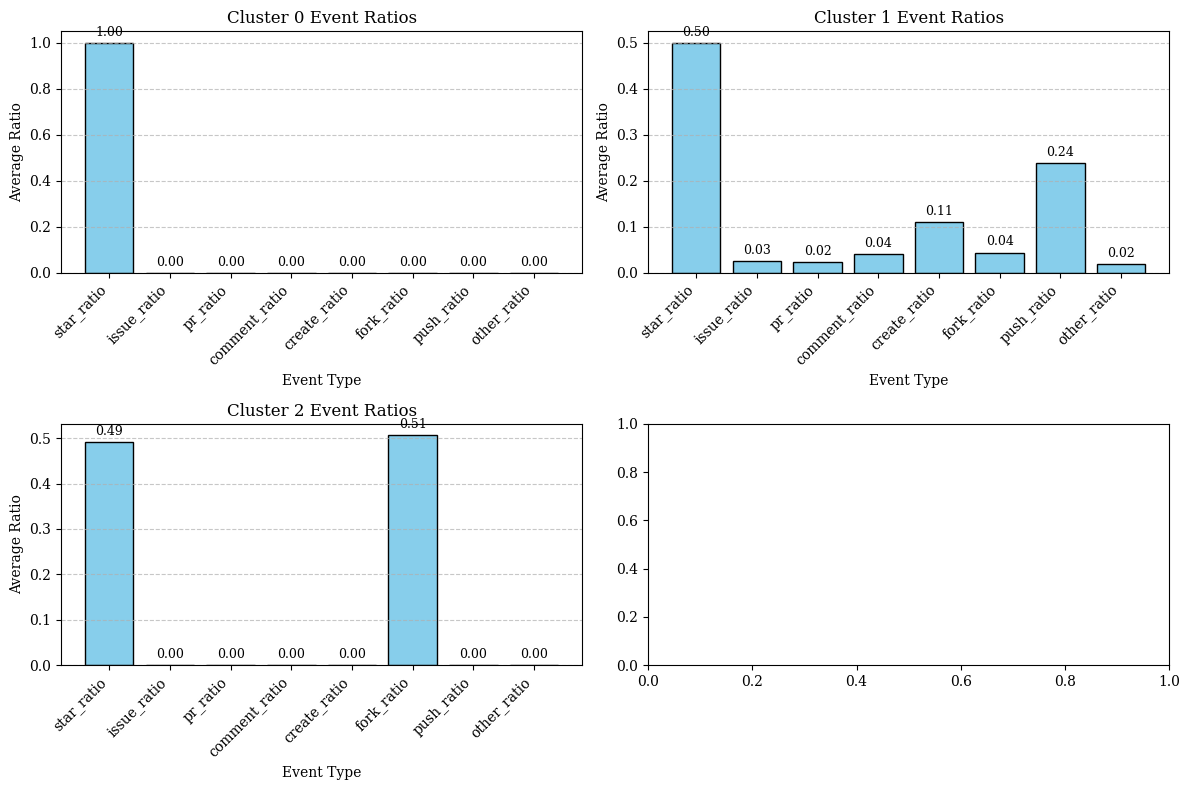

In [ ]:

event_types = ['star_ratio', 'issue_ratio', 'pr_ratio','comment_ratio',
               'create_ratio', 'fork_ratio', 'push_ratio', 'other_ratio']

clusters = cluster_means.index.tolist()

# Create the figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Loop over clusters and corresponding axes
for idx, (cluster, ax) in enumerate(zip(clusters, axes)):
    # Get the ratios for the current cluster
    ratios = cluster_means.loc[cluster, event_types]
    
    # Plot the bar chart
    bars = ax.bar(event_types, ratios, color='skyblue', edgecolor='black')
    
    # Set the title and labels
    ax.set_title(f'Cluster {cluster} Event Ratios')
    ax.set_xlabel('Event Type')
    ax.set_ylabel('Average Ratio')
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(event_types, rotation=45, ha='right')
    
    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add data labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
        
plt.tight_layout()

plt.show()


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

unique_clusters = [0,1,2]
perplexities = [30, 50, 100]
tsne_df = {}
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, n_iter=1000, random_state=114514)
    tsne_results = tsne.fit_transform(scaled_features)

    tsne_df[p] = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df[p]['cluster'] = actor_features['cluster']

    


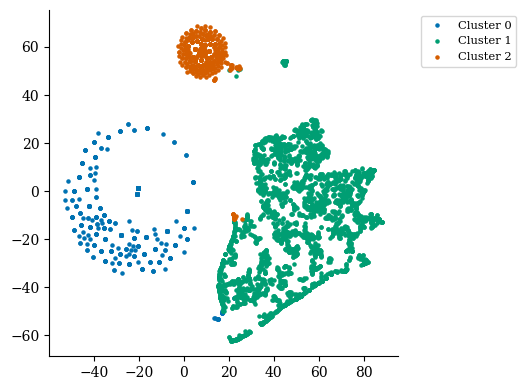

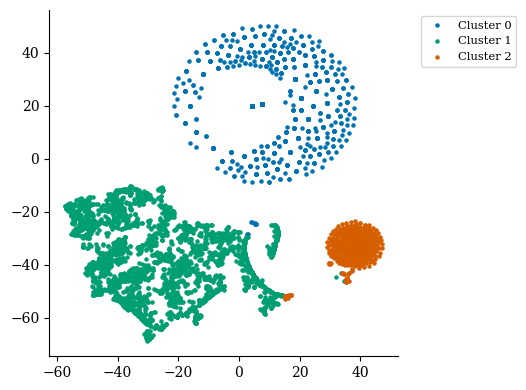

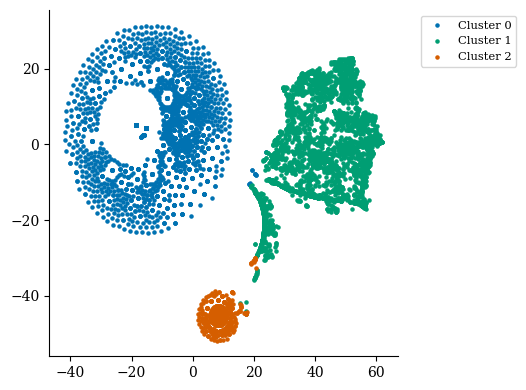

In [8]:

color_dict = {0: "C0", 1: "C1", 2: "C2", 3:"C3"}

for p in perplexities:
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
    ax.grid(False)
    for cluster in unique_clusters:
        cluster_data = tsne_df[p][tsne_df[p]['cluster'] == cluster]
        
        ax.scatter(
            cluster_data['TSNE1'],
            cluster_data['TSNE2'],
            c=[color_dict[cluster]],    # Color assigned to this cluster
            label=f'Cluster {cluster}', # Label for the legend
            s=5,                       # Marker size; adjust as needed
            marker='o'
        )

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    fig.savefig(f"plots/tsne-users-{p}.pdf", bbox_inches="tight", dpi=300)


In [ ]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns

def sample_actors_per_cluster(df, n=10):
    def sample_group(group):
        return group.sample(n=min(len(group), n), random_state=42)
    sampled = df.groupby('cluster').apply(sample_group).reset_index(drop=True)
    return sampled[['actor', 'cluster']]

sampled_actors = sample_actors_per_cluster(actor_features, n=10)

print(sampled_actors)
actors_list = sampled_actors['actor'].unique().tolist()
query = {'actor': {'$in': actors_list}}
cursor = collection.find(query)
events_df = pd.DataFrame(list(cursor))

events_df['created_at'] = pd.to_datetime(events_df['created_at'])
actor_cluster_map = dict(zip(sampled_actors['actor'], sampled_actors['cluster']))
events_df['cluster'] = events_df['actor'].map(actor_cluster_map)
events_df = events_df.dropna(subset=['cluster'])
events_df['cluster'] = events_df['cluster'].astype(int)

sns.set(style='whitegrid')
event_types = events_df['type'].unique()
event_types.sort()
event_type_to_num = {event_type: idx for idx, event_type in enumerate(event_types)}
num_to_event_type = {idx: event_type for event_type, idx in event_type_to_num.items()}

clusters = sampled_actors['cluster'].unique()

for cluster in clusters:
    actors_in_cluster = sampled_actors[sampled_actors['cluster'] == cluster]['actor'].tolist()
    
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), sharex=True)
    axes = axes.flatten()
    
    for idx, actor in enumerate(actors_in_cluster):
        ax = axes[idx]
        
        actor_events = events_df[events_df['actor'] == actor].copy()
        
        if actor_events.empty:
            ax.set_visible(False)
            continue
        
        actor_events['event_num'] = actor_events['type'].map(event_type_to_num)
        
        sns.scatterplot(
            data=actor_events,
            x='created_at',
            y='event_num',
            hue='type',
            palette='tab10',
            ax=ax,
            legend=False,
            s=50
        )
        
        ax.set_title(f'Actor: {actor}')
        ax.set_ylabel('Event Type')
        ax.set_xlabel('Time')
        
        ax.set_yticks(range(len(event_types)))
        ax.set_yticklabels(event_types)
        
    # Hide any unused subplots
    for idx in range(len(actors_in_cluster), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig.suptitle(f'Activity Timelines for Cluster {cluster}', fontsize=16)
    fig.subplots_adjust(top=0.94)
    plt.show()

In [15]:
import pandas as pd
import requests
import os
import time

# Step 1: Sample 100 actors per cluster
def sample_actors_per_cluster(df, n=100):
    def sample_group(group):
        return group.sample(n=min(len(group), n), random_state=42)
    sampled = df.groupby('cluster').apply(sample_group).reset_index(drop=True)
    return sampled[['actor', 'cluster']]

# Assuming 'actor_features' DataFrame is already defined
actor_features['actor'] = actor_features['actor'].astype(str)
sampled_actors = sample_actors_per_cluster(actor_features, n=100)

# Display number of sampled actors per cluster
sampled_counts = sampled_actors['cluster'].value_counts().sort_index()
print("Number of sampled actors per cluster:")
print(sampled_counts)

# Step 2: Set up authentication
GITHUB_TOKEN = GITHUB_TOKENS[0]

if not GITHUB_TOKEN:
    raise Exception("Please set your GitHub Personal Access Token in the GITHUB_TOKEN environment variable.")

headers = {
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github.v3+json"
}

def is_github_user_deleted(login_id):
    url = f'https://api.github.com/users/{login_id}'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return False  # User exists
    elif response.status_code == 404:
        return True   # User does not exist or has been deleted
    else:
        print(f"Error checking user '{login_id}': HTTP {response.status_code}")
        return None    # Unknown error

# Step 4: Check sampled actors and collect results
deleted_status = {}

clusters = sampled_actors['cluster'].unique()

for cluster in clusters:
    cluster_actors = sampled_actors[sampled_actors['cluster'] == cluster]['actor'].tolist()
    total_actors = len(cluster_actors)

    print(f"\nProcessing Cluster {cluster} with {total_actors} sampled actors...")

    for idx, actor in enumerate(cluster_actors, 1):
        # Check rate limit every 100 requests
        if idx % 100 == 0:
            rate_limit_url = 'https://api.github.com/rate_limit'
            rate_response = requests.get(rate_limit_url, headers=headers)
            rate_data = rate_response.json()
            remaining = rate_data['resources']['core']['remaining']
            reset_time = rate_data['resources']['core']['reset']
            if remaining < 10:
                sleep_time = max(reset_time - time.time(), 0) + 10  # Add buffer time
                print(f"Rate limit low. Sleeping for {sleep_time / 60:.2f} minutes.")
                time.sleep(sleep_time)

        # Check if the actor's account is deleted
        try:
            is_deleted = is_github_user_deleted(actor)
            deleted_status[actor] = {'cluster': cluster, 'is_deleted': is_deleted}
        except Exception as e:
            print(f"Error processing actor '{actor}': {e}")
            deleted_status[actor] = {'cluster': cluster, 'is_deleted': None}

        # Optional: Sleep between requests to avoid hitting rate limits
        time.sleep(0.1)  # Adjust as needed

    print(f"Finished processing Cluster {cluster}.")

# Step 5: Calculate percentages per cluster
status_df = pd.DataFrame.from_dict(deleted_status, orient='index').reset_index()
status_df.rename(columns={'index': 'actor'}, inplace=True)

# Remove actors where 'is_deleted' is None (errors)
status_df = status_df[status_df['is_deleted'].notnull()]

# Group by cluster and calculate percentages
grouped = status_df.groupby('cluster').agg(
    total_sampled_actors=('actor', 'count'),
    deleted_actors=('is_deleted', 'sum')  # True is 1, False is 0
).reset_index()

grouped['deleted_percentage'] = (grouped['deleted_actors'] / grouped['total_sampled_actors']) * 100

# Display the results
print("\nPercentage of Deleted Actors per Cluster (Based on Sample):")
print(grouped[['cluster', 'total_sampled_actors', 'deleted_actors', 'deleted_percentage']])


/tmp/ipykernel_1379899/1646521603.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df.groupby('cluster').apply(sample_group).reset_index(drop=True)


Number of sampled actors per cluster:
cluster
0    100
1    100
2    100
Name: count, dtype: int64

Processing Cluster 0 with 100 sampled actors...
Finished processing Cluster 0.

Processing Cluster 1 with 100 sampled actors...
Finished processing Cluster 1.

Processing Cluster 2 with 100 sampled actors...
Finished processing Cluster 2.

Percentage of Deleted Actors per Cluster (Based on Sample):
   cluster  total_sampled_actors  deleted_actors  deleted_percentage
0        0                   100              19                19.0
1        1                   100              12                12.0
2        2                   100              22                22.0
